In [ ]:
#!pip install torch 

#!pip install --upgrade --force-reinstall nltk

#!pip install transformers==4.28.1
#!pip install huggingface_hub==0.13.4
#!pip install deepspeed
#!pip install sentencepiece
#!pip install kaggle pandas

#!pip install pandas numpy seaborn matplotlib plotly scikit-learn wordcloud

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
from sentence_transformers import SentenceTransformer


from scipy.stats import zscore


### Initial Data Import (Filtering Step 1/3)

- Since the data is so poorly distributed, we need almost 200,000 before it contains enough rows that 10,000 can be split into each category numbers.
- All rows arent used, all but 10,000 are later filtered out within the Filtering step 2, which is just under Preprocessing (minimize if possible)


In [ ]:
df = pd.read_json("arxiv_data/arxiv-metadata-oai-snapshot.json", lines=True, nrows=300000)


### PreProcessing

- Pretty much your unchanged preprocessing code lumped into one block, so it can be easily run then condenced to more easily see next step in filtering

In [60]:
category_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'
}

subject_map = {
    "Astrophysics & Cosmology": ["astro-ph", "astro-ph.CO", "astro-ph.EP", "astro-ph.GA", "astro-ph.HE", "astro-ph.IM", "astro-ph.SR"],
    "Condensed Matter Physics": ["cond-mat.dis-nn", "cond-mat.mes-hall", "cond-mat.mtrl-sci", "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft", "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con"],
    "Computer Science": ["cs.AI", "cs.AR", "cs.CC", "cs.CE", "cs.CG", "cs.CL", "cs.CR", "cs.CV", "cs.CY", "cs.DB", "cs.DC", "cs.DL", "cs.DM", "cs.DS", "cs.ET", "cs.FL", "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG", "cs.LO", "cs.MA", "cs.MM", "cs.MS", "cs.NA", "cs.NE", "cs.NI", "cs.OH", "cs.OS", "cs.PF", "cs.PL", "cs.RO", "cs.SC", "cs.SD", "cs.SE", "cs.SI", "cs.SY"],
    "Econometrics & Finance": ["econ.EM", "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR", "q-fin.RM", "q-fin.ST", "q-fin.TR"],
    "Electrical Engineering & Signal Processing": ["eess.AS", "eess.IV", "eess.SP"],
    "General & Theoretical Physics": ["gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", "math-ph", "physics.acc-ph", "physics.ao-ph", "physics.app-ph", "physics.atm-clus", "physics.atom-ph", "physics.bio-ph", "physics.chem-ph", "physics.class-ph", "physics.comp-ph", "physics.data-an", "physics.ed-ph", "physics.flu-dyn", "physics.gen-ph", "physics.geo-ph", "physics.hist-ph", "physics.ins-det", "physics.med-ph", "physics.optics", "physics.plasm-ph", "physics.pop-ph", "physics.soc-ph", "physics.space-ph", "quant-ph"],
    "Mathematics": ["math.AC", "math.AG", "math.AP", "math.AT", "math.CA", "math.CO", "math.CT", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM", "math.GN", "math.GR", "math.GT", "math.HO", "math.IT", "math.KT", "math.LO", "math.MG", "math.MP", "math.NA", "math.NT", "math.OA", "math.OC", "math.PR", "math.QA", "math.RA", "math.RT", "math.SG", "math.SP", "math.ST"],
    "Nonlinear Sciences": ["nlin.AO", "nlin.CD", "nlin.CG", "nlin.PS", "nlin.SI"],
    "Nuclear Physics": ["nucl-ex", "nucl-th"],
    "Quantitative Biology": ["q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT", "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"],
    "Statistics & Data Science": ["stat.AP", "stat.CO", "stat.ME", "stat.ML", "stat.OT", "stat.TH"]
}

# If there are multiple categories associated with the document, take the first one
df['categories'] = df['categories'].str.split().str[0]

# Add subjects instead of the category
category_to_subject = {}
for subject, categories in subject_map.items():
    for category in categories:
        category_to_subject[category] = subject

# Apply the corrected mapping
df['mapped_categories'] = df['categories'].map(category_map)
df['subject_map'] = df['categories'].map(category_to_subject)
df['mapped_categories'] = df['mapped_categories'].fillna('Unknown Category') #should not exist
df['subject_map'] = df['subject_map'].fillna('Unknown Subject')  #should not exist

# Print unique subject mappings (ie. without duplicates)
df[['categories', 'mapped_categories', 'subject_map']].drop_duplicates().head(5)



# Drop rows where 'title' or 'abstract' are missing
df_cleaned = df.dropna(subset=['title', 'abstract'])

# Function to clean text
def clean_text(text):
    # Remove extra spaces and special characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Apply text cleaning to 'title' and 'abstract' columns
df_cleaned['title'] = df_cleaned['title'].apply(clean_text)
df_cleaned['abstract'] = df_cleaned['abstract'].apply(clean_text)

# Remove duplicate rows based on 'title' and 'abstract'
df_cleaned = df_cleaned.drop_duplicates(subset=['title', 'abstract'])

# Convert the update date to a proper datetime format
df_cleaned['update_date'] = pd.to_datetime(df_cleaned['update_date'], errors='coerce')

# Extract the year from the update date
df_cleaned['year'] = df_cleaned['update_date'].dt.year

# Exclude rows where the category is "Unknown Category"
df_cleaned = df_cleaned[df_cleaned['mapped_categories'] != 'Unknown Category']

"""
Reformats Author Data Into Clean List
"""
def clean_contributors(author_string):

    #Remove Anything In Brackets
    s = re.sub(r'\([^)]*\)', '', author_string)

    #Remove All "and"
    s = re.sub(r'\band\b', '', s, flags=re.IGNORECASE)

    #Remove All "\n"
    s = s.replace('\n', '') 

    #Split And Trim
    return [part.strip() for part in s.split(',') if part.strip()]
    
#Cleans The Author Columns
df_cleaned['authors_parsed'] = df_cleaned['authors'].apply(clean_contributors)
df_cleaned = df_cleaned.drop(columns='authors')

#Store Count
df_cleaned['contributors'] = df['authors_parsed'].apply(len)

#Order 
df_cleaned = df_cleaned.sort_values(by='id')

In [61]:
def generate_equalized_sample(total, data):

  #Counting Categories  
  key_categories = data['subject_map'].nunique()

  #Counting Sample Per Category We Want
  samples_per_category = int(total / key_categories)

  #Selecting These Samples
  data = (
      data.groupby('subject_map')
      .apply(lambda x: x.sample(n=min(samples_per_category, len(x)), random_state=25))
      .reset_index(drop=True)
  )
  return data

In [62]:
def generate_expanded_data(data):

    #Generating Each Individual Contribution (Paper, Author)
    df_contributions = (
        data
        .assign(
            contributors = data["authors_parsed"].apply(len)
        )
        .explode("authors_parsed", ignore_index=True)
        .rename(columns={"authors_parsed":"contributor"})
        .assign(
            is_lead = lambda d: d.apply(lambda row: any(w.lower() in re.split(r'[^A-Za-z]+', row['contributor'].lower()) for w in re.split(r'[^A-Za-z]+', row['submitter'].lower())), axis=1)
        )
        .loc[:, lambda d: ~d.columns.isin(["authors_parsed","unclean_contributor", "submitter", "authors", "comments", "journal-ref", "doi", "license", "versions", "update_date", "report-no", "categories", "title", "abstract"])]
    )

    #Generating Each Individual Author
    df_authors = (
        df_contributions
        .groupby("contributor")
        .agg(
            papers = ('id', 'count'),
            earliest = ('year', 'min'),
            latest = ('year', 'max'),
            solo = ('contributors', lambda x: (x==1).sum()),
            average_size = ('contributors', 'mean'),
            mapped_category_count = ('mapped_categories', lambda x: x.dropna().nunique()),
            subject_map_count = ('subject_map', lambda x: x.dropna().nunique())
        )
        .reset_index()
        )

    #Merging Data To Make Next Steps Easier
    df_contributions = df_contributions.merge(df_authors[['contributor', 'earliest', 'latest', 'papers']], on='contributor', how='left')
    paper_sums = df_contributions.groupby('id')['papers'].sum().reset_index(name='total_papers')
    data = data.merge(paper_sums, on='id', how='left')
    
    return data, df_contributions, df_authors

### Initial Data Filtering (Filtering Step 2/3)

- Selecting a random subject of each category, however practically given some categories barely have enough, this means its taking all in those categorys, and taking a small sample of the larger ones
- Random state currently set for consistency, however can be changed

### Final Data Filtering (Filtering Step 3/3)

In [64]:
#First We Get A Smaller Sample
df_cleaned = generate_equalized_sample(10000, df_cleaned)

#Then Generate Some Stats
df_cleaned, df_contributions, df_authors = generate_expanded_data(df_cleaned)

C:\Users\ldunc\AppData\Local\Temp\ipykernel_31412\1668020805.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(samples_per_category, len(x)), random_state=25))


### Category Distribution
- Highlighting the new more equalized distribution, please note what while the larger categories are equalized the smaller ones arent, nor should they be as the distribution of effort/papers within a category, represents a valid use of effort within the category illustrative of its true meaning


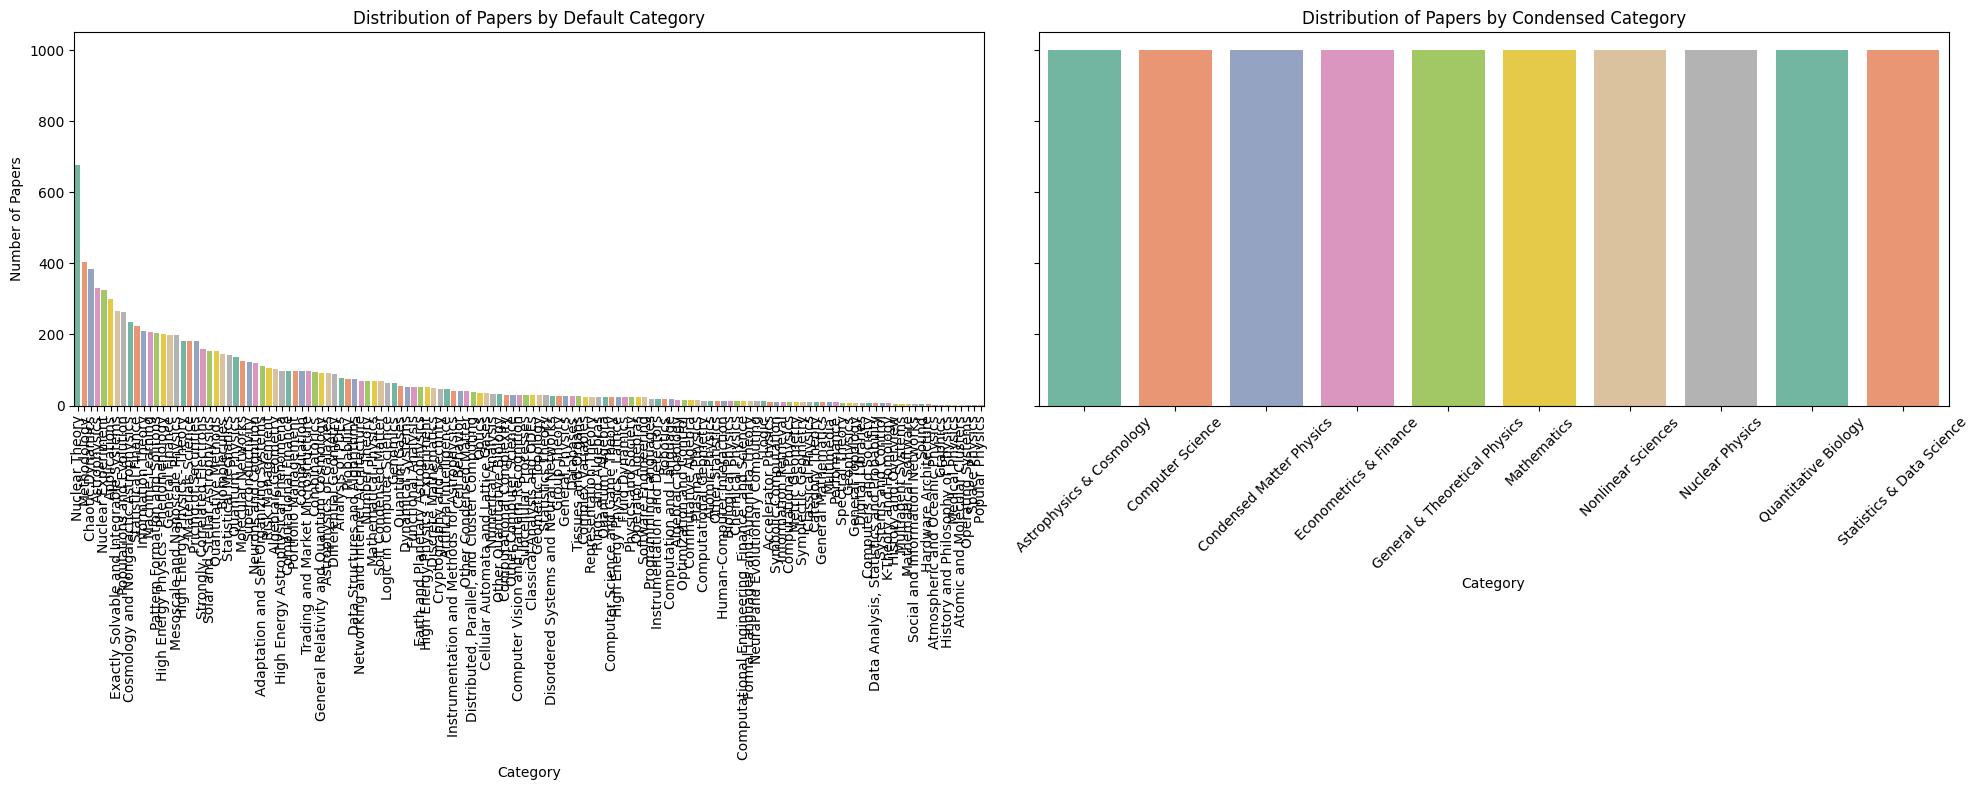

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Count categories
counts_orig = df_cleaned['mapped_categories'].value_counts().reset_index()
counts_orig.columns = ['Category', 'Count']

counts_cond = df_cleaned['subject_map'].value_counts().reset_index()
counts_cond.columns = ['Category', 'Count']

# Plot original categories with hue workaround
sns.barplot(data=counts_orig,x='Category',y='Count',hue='Category',palette='Set2',legend=False,ax=axes[0])
axes[0].set_title('Distribution of Papers by Default Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Papers')
axes[0].tick_params(axis='x', rotation=90)

# Plot condensed categories with hue workaround
sns.barplot(data=counts_cond,x='Category',y='Count', hue='Category',palette='Set2',legend=False,ax=axes[1])
axes[1].set_title('Distribution of Papers by Condensed Category')
axes[1].set_xlabel('Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

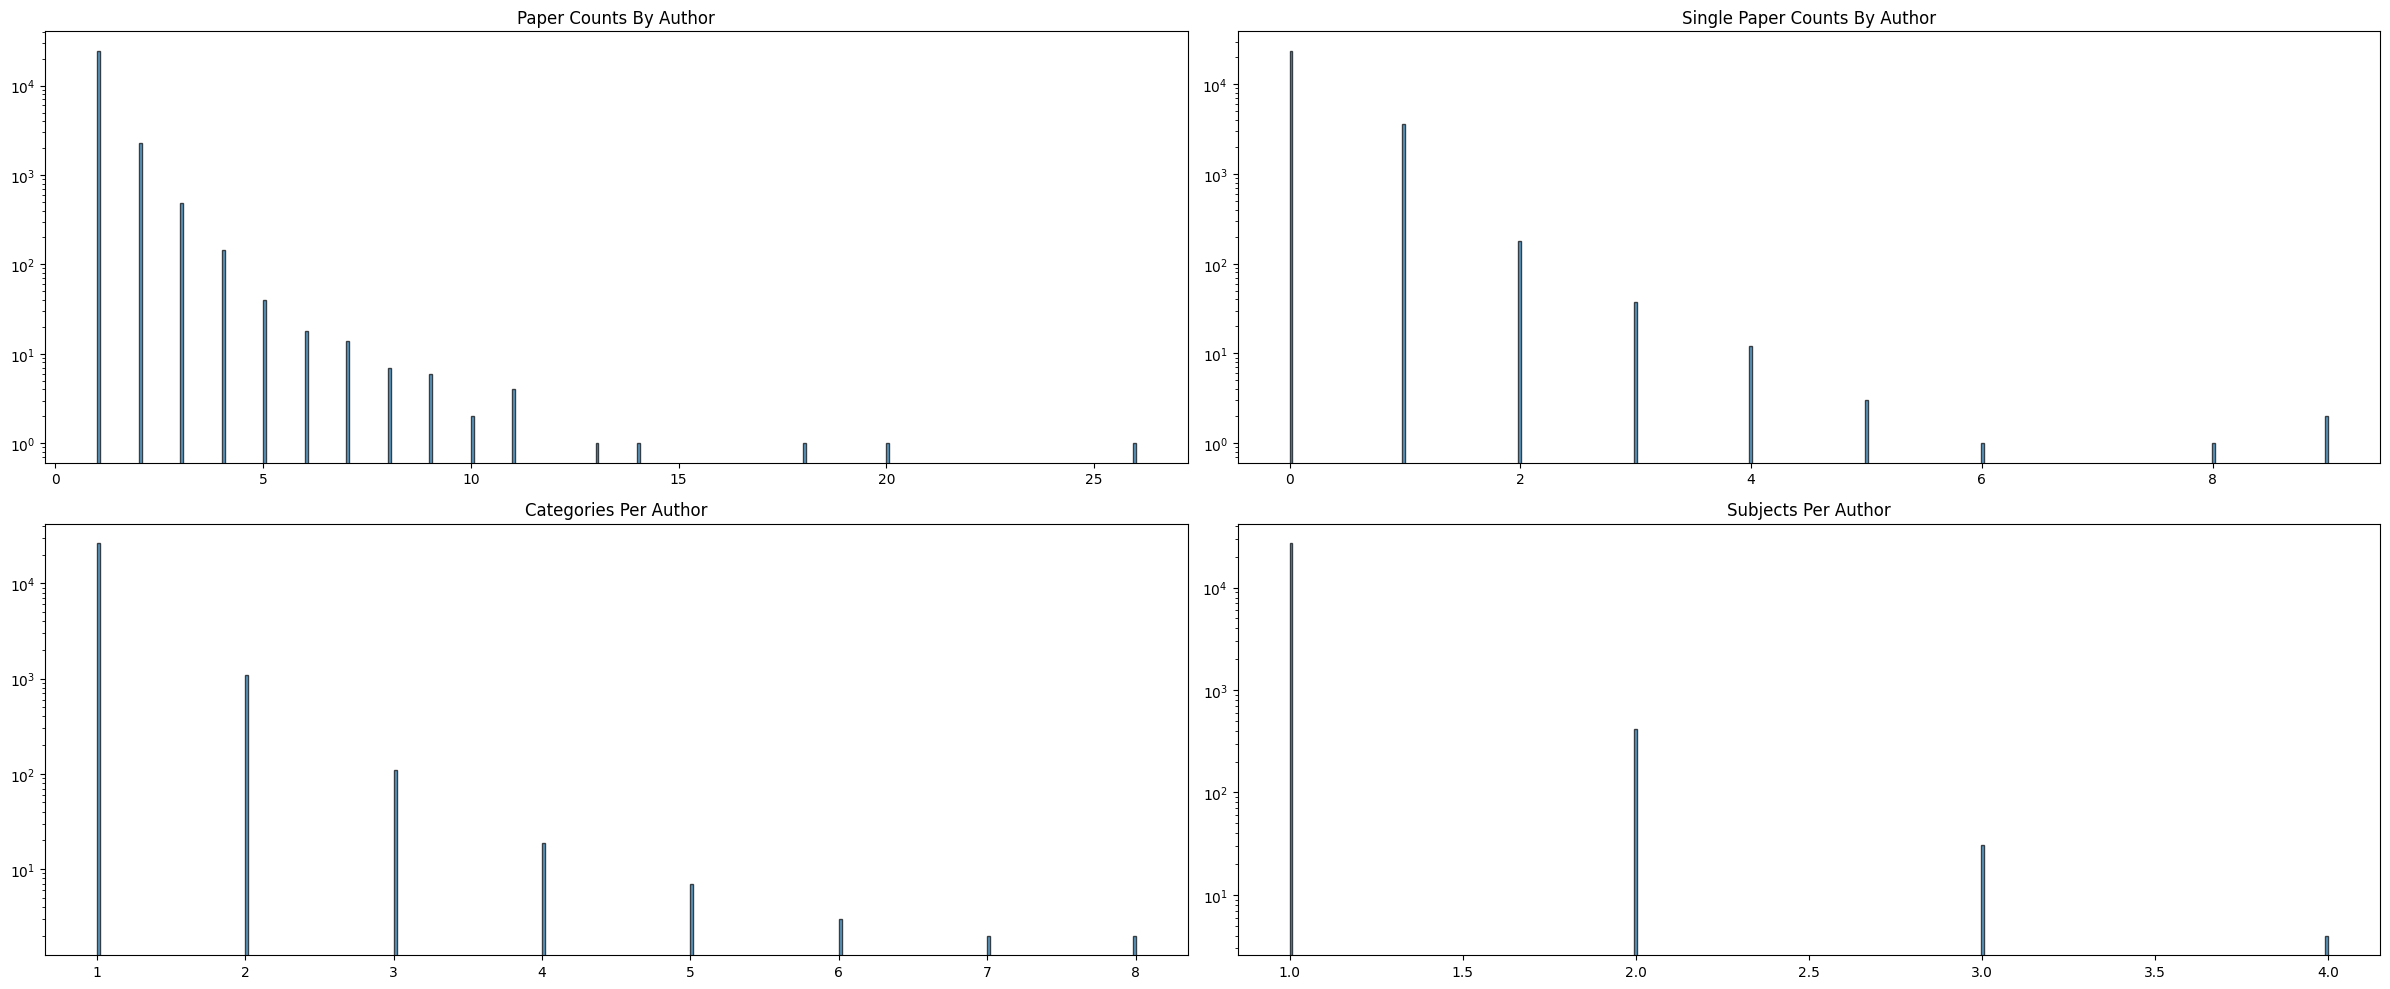

In [66]:
"""
A Generic Function To Plot The Distribution Of A Specified Column
"""
def plot_distribution(ax, data, title):
    ax.hist(data, bins=350, edgecolor="black", alpha=0.7)
    ax.set_yscale('log')
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(24, 10)) 

plot_distribution(axes[0,0], df_authors["papers"], "Paper Counts By Author")
plot_distribution(axes[0,1], df_authors["solo"], "Single Paper Counts By Author")
plot_distribution(axes[1,0], df_authors["mapped_category_count"], "Categories Per Author")
plot_distribution(axes[1,1], df_authors["subject_map_count"], "Subjects Per Author")
plt.tight_layout()
plt.show()

### Embedding
- Code to utilize both BERT and Sentence Embedding (although only bert is used below)
- Largely your same code, described by the existing heading

In [72]:
#Models Used
model_full_bert = 'bert-base-uncased'
model_sentence = 'all-MiniLM-L6-v2'

#Tokenizers And Models Required
full_tokenizer = BertTokenizer.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
full_model = BertModel.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
sentence_model = SentenceTransformer(model_sentence)

"""
Your Original Method: Averaging Word Embeddings, Better For Finding Keyword Similarity
"""
def original_token_embedding(text):

        inputs = full_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

        with torch.no_grad(): outputs = full_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings.numpy().flatten()

"""
Generates Embedding According To Chosen Method
"""
def generate_embeddings(method, applied_on):
        if method == "token":
                return applied_on.apply(original_token_embedding)
        else:
                return list(sentence_model.encode(applied_on.tolist(), batch_size=128, show_progress_bar=True))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Generating Initial Embeddings

- Repeating your generation of embeddings for both title and abstract, then in addition simply averaging them. 

In [74]:

df_cleaned["title_embeddings"] = generate_embeddings("token", df_cleaned['title'])

In [75]:
df_cleaned["abstract_embeddings"] = generate_embeddings("token", df_cleaned['abstract'])

In [78]:
df_cleaned['sentence_embeddings'] = generate_embeddings('sentence', df_cleaned['title'] + ":" + df_cleaned['abstract'])

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
#####df_cleaned.to_csv("df_cleaned.csv", index=False)

In [80]:
df_cleaned = pd.read_csv("df_cleaned.csv")
df_cleaned.shape

(10000, 21)

In [81]:
df_cleaned['title_embeddings'] = df_cleaned['title_embeddings'].apply(lambda s: np.fromstring(s.strip("[]"), sep=' '))

df_cleaned['abstract_embeddings'] = df_cleaned['abstract_embeddings'].apply(lambda s: np.fromstring(s.strip("[]"), sep=' '))

df_cleaned['sentence_embeddings'] = df_cleaned['sentence_embeddings'].apply(lambda s: np.fromstring(s.strip("[]"), sep=' '))


In [82]:
df_cleaned["joined_embeddings"] = (np.array(df_cleaned["title_embeddings"]) + np.array(df_cleaned["abstract_embeddings"]))/2

In [89]:
df_contributions = df_contributions.merge(df_cleaned[['id', 'title_embeddings', 'abstract_embeddings', 'sentence_embeddings', 'joined_embeddings']], on='id', how='left') 

### Additional Embedding Layer: Recursive Aggregation

- The embeddings generated above can be further refined by applying them through author focused aggregation, so as to better represent the additional nuance contained by the specific authorship patterns within the data.

- Taking the initial ((title/abstract)) embeddings for each paper, by aggregating the embeddings of all papers contributed to by each author, utilizing the role of this author (led or not), the temperal point its publishing occured within their career, and number of contributors to generate an embedding representing that authors average "area of expertise" or "unique skill".

- For each paper, an embedding can then be regenerated by aggregating this author layer, regenerating the "content" representation of each papers, as the aggregate of the author embeddings among authors who contributed within it, to incorporate varience and tendancies within author publishing, utilizing each authors role (led or not), ......the magnitude of their papers, 


- Importance: Allows papers to be brought together by their practical similarity in conjuction to just theoretical, actual occurances of varience in subject expertise and publishship, collaborations, practical barriers and career topic progression.

In [90]:
"""
Generates The Average Embeddings For A Category Using The Weighted Papers Within It
"""
def paper_contribution_to_category(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis = 0 ,
        weights = np.sqrt(group['contributors'].values)  * #Use Contributor
                  np.sqrt(group['total_papers']/group['contributors']) #Higher Publishing experience
    )

"""
Generates The Average Author Embedding Using Weighted Papers They Contributed To
"""
def paper_contribution_to_author(group,chosen_embedding):
    
    duration = np.maximum(group['latest']-group['earliest'],1)
    point_within = group['year']-group['earliest']

    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0   # ,
        #weights=  np.sqrt(np.log(point_within/duration + 2)*   #Use Point In Career
        #          ( 1 + group['is_lead']*5 ) *   #Role In Paper
        #         (np.power(1 / group['contributors'], 0.5))  # Inverse Contributors 

                
        #)
    )


"""
Generates The Average Paper Embedding Usings Weighted Authors That Contributed To It
"""
def authors_contribution_to_paper(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0    ,
        weights=     ( 1 + group['is_lead']*5 ) * #More If Author Leading It
                    np.sqrt(group['papers']) * #Move If Many Papers Mad
                   (1 - 0.5*(group['papers'] == 1)) #Less If This Is Only Paper Made By Author (Dilutes)
    )
            

In [91]:
""""
A Method That Generates An Alternative Embedding For A Paper, By Generating An Embedding For Each Author, 
Then Aggregating Each Papers Contributors Embeddings 
"""
def generate_alternative_embeddings(chosen_embeddings, contributions):

    #Generate Author Embedding
    author_embeddings = (
        contributions
        .groupby('contributor')
        .apply(lambda group: paper_contribution_to_author(group,chosen_embeddings), include_groups=False)
        .reset_index(name = "author_" + chosen_embeddings)
    )

    #Merge To Join This Data
    contributions = contributions.merge(author_embeddings, on='contributor', how='left')

    #Generate New Paper Embedding
    alternative_embeddings = (
        contributions
        .groupby('id')
        .apply(lambda group: authors_contribution_to_paper(group, "author_" + chosen_embeddings), include_groups=False)
        .sort_index()
        .reset_index(name= "alternative_" + chosen_embeddings)
    )

    #Returning New Embedding
    return list(alternative_embeddings["alternative_" + chosen_embeddings])

### NOTE: Generating New Embeddings

- Regenerating both the title, and abstract embeddings, using this method

In [92]:
#Alternative Using The Joined (BERT, Title + Abstract)
df_cleaned['alternative_joined_embeddings'] = generate_alternative_embeddings(chosen_embeddings="joined_embeddings", contributions=df_contributions)

#Alternative Using The Sentence
df_cleaned['alternative_sentence_embeddings'] = generate_alternative_embeddings(chosen_embeddings="sentence_embeddings", contributions=df_contributions)

### Cosine Similarity:

- Generates the cosine similarity of categoryies using your original average pairwise, unweighted function; on both the original BERT embeddings, as well as the alternative layer.
- In real terms, the first highlights more absolute range, which makes sense as the second effectively pulls categories together, and measures the ratio to which they do so. (Thus observe the values closely centred around the average ~0.8)

- Interesting things to note are some obvious conclusions, such are Computer Science + Data Science being similar in the first, while the second seems to highlight a much layer practical overlap between Quantative Biology and Concensced Matter Physics then would be expected. while astrophysics seems to be the biggest dark horse, which i assume comes from the fact that while it may be similar to other disciplines technically, its seperate enough practically in subject matter, that there is less overlap in authors (invisible barrier)

In [103]:
"""
Generates A Similarity Matrix For Categories Using Pairwise Average Of The Average Of 2 Embeddings
"""
def create_similarity_matrix(embedding_col, df, method):

    cats = df['subject_map'].unique()

    if method == 'total':

        sim_matrix = cosine_similarity(np.stack(df[embedding_col]))
    
        cat_sim = np.zeros((len(cats), len(cats)))
    
        for i, c1 in enumerate(cats):
            i1 = df['subject_map'] == c1
            for j, c2 in enumerate(cats):
                i2 = df['subject_map'] == c2
                cat_sim[i, j] = sim_matrix[np.ix_(i1, i2)].mean()

        np.fill_diagonal(cat_sim, np.nan)

        return pd.DataFrame(cat_sim, index=cats, columns=cats)
    
    else:

        category_similarity = (
            df
            .groupby('subject_map')
            .apply(lambda group: paper_contribution_to_category(group,embedding_col), include_groups=False)
            .reset_index(name = "author_" + embedding_col)
        )

        sim_matrix = cosine_similarity(np.stack(category_similarity["author_" + embedding_col]))

        np.fill_diagonal(sim_matrix, np.nan)

        return pd.DataFrame(sim_matrix, index=cats, columns=cats)

        


def plot_similarity_matrix(ax, similarity, title, cmap="magma"):
    sns.heatmap(similarity, ax=ax, annot=True, cmap=cmap)
    ax.set_title("Cosine Similarity " + title)
    ax.set_xlabel("Category")
    ax.set_ylabel("Category")

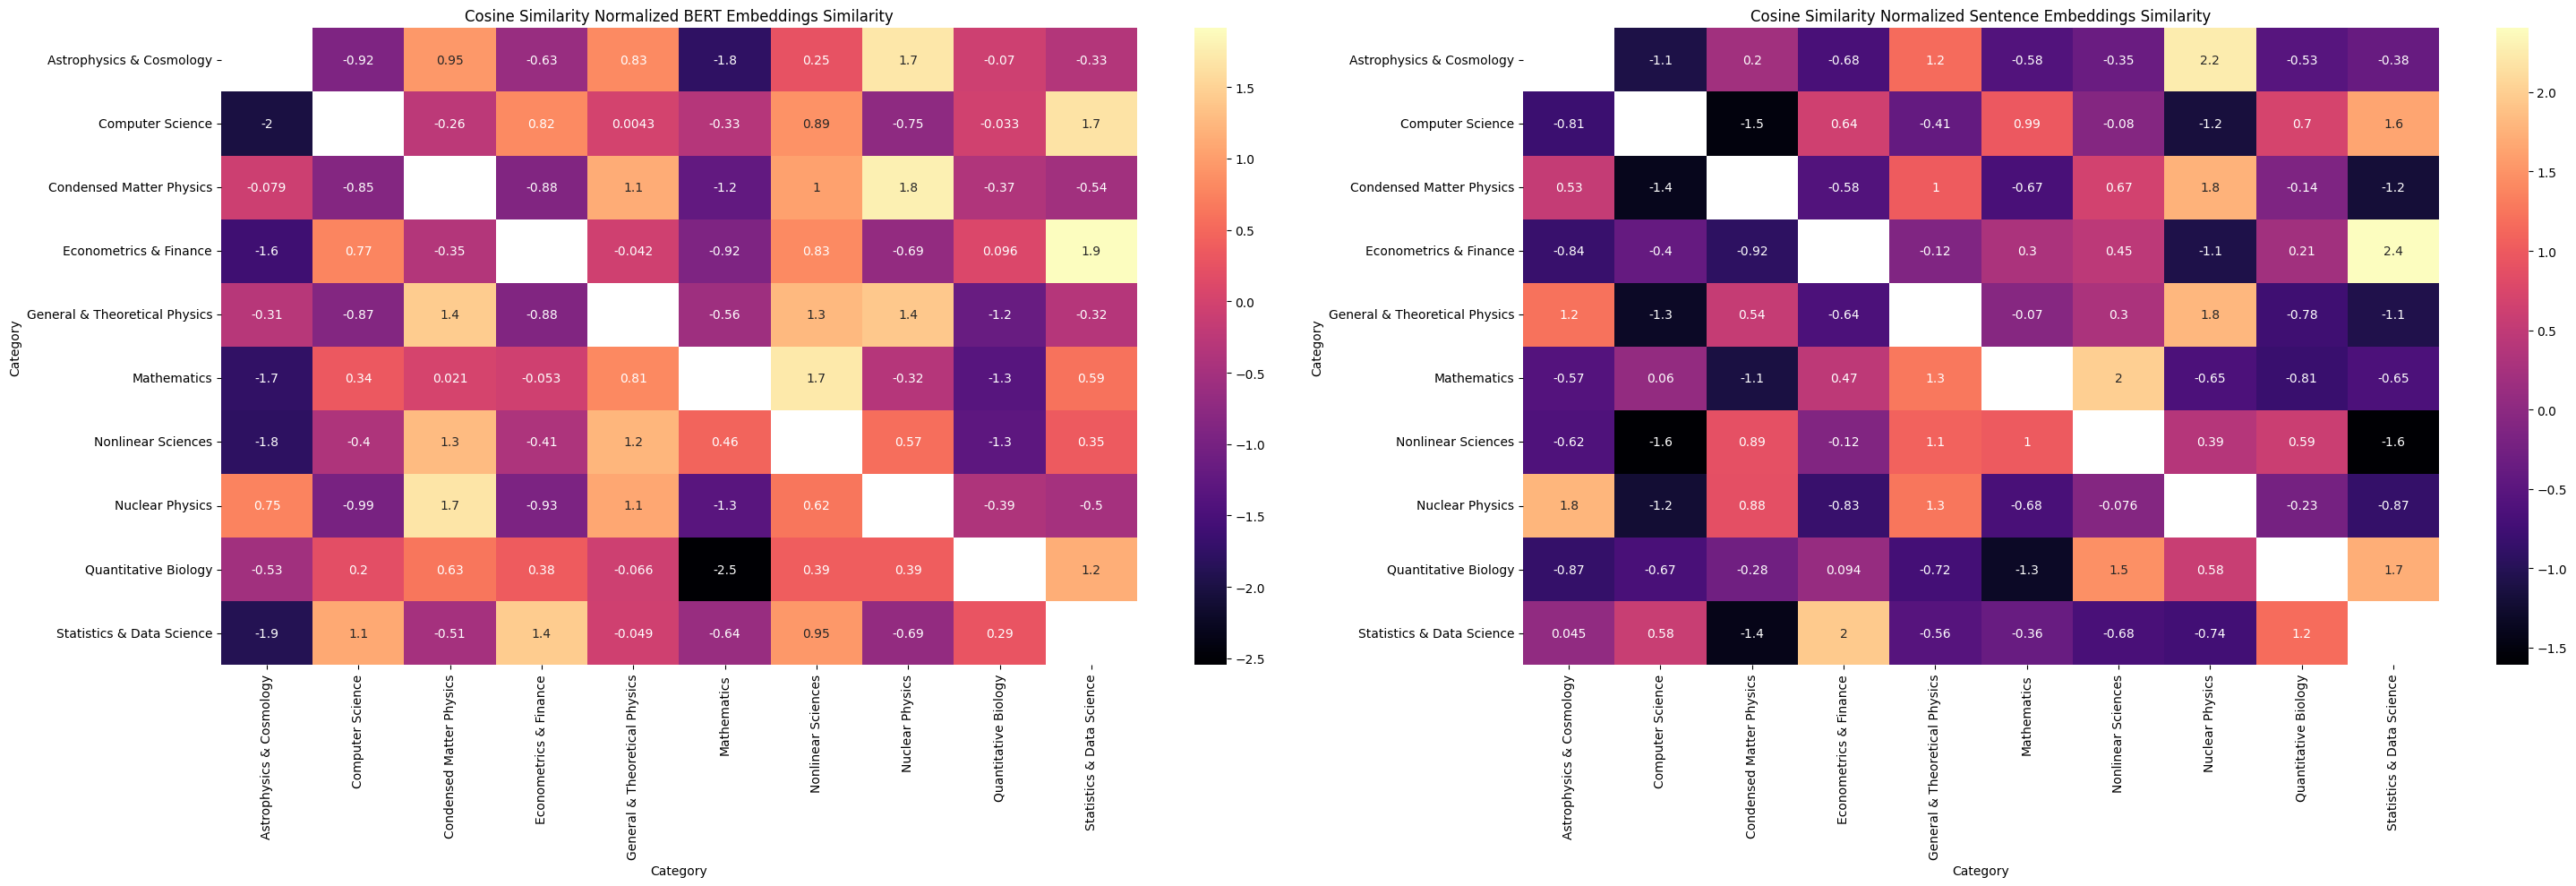

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(30, 10))

#Original Method
original_method = create_similarity_matrix('joined_embeddings', df_cleaned, method='other')
original_norm = pd.DataFrame(zscore(original_method, axis=1, nan_policy='omit'), index=original_method.index, columns=original_method.columns)
plot_similarity_matrix(axes[0], original_norm, "Normalized BERT Embeddings Similarity")

#Alternative Method
alternative_method = create_similarity_matrix('sentence_embeddings', df_cleaned, method='other')
alternative_norm = pd.DataFrame(zscore(alternative_method, axis=1, nan_policy='omit'), index=alternative_method.index, columns=alternative_method.columns)
plot_similarity_matrix(axes[1], alternative_norm, "Normalized Sentence Embeddings Similarity")

plt.tight_layout()
plt.show()

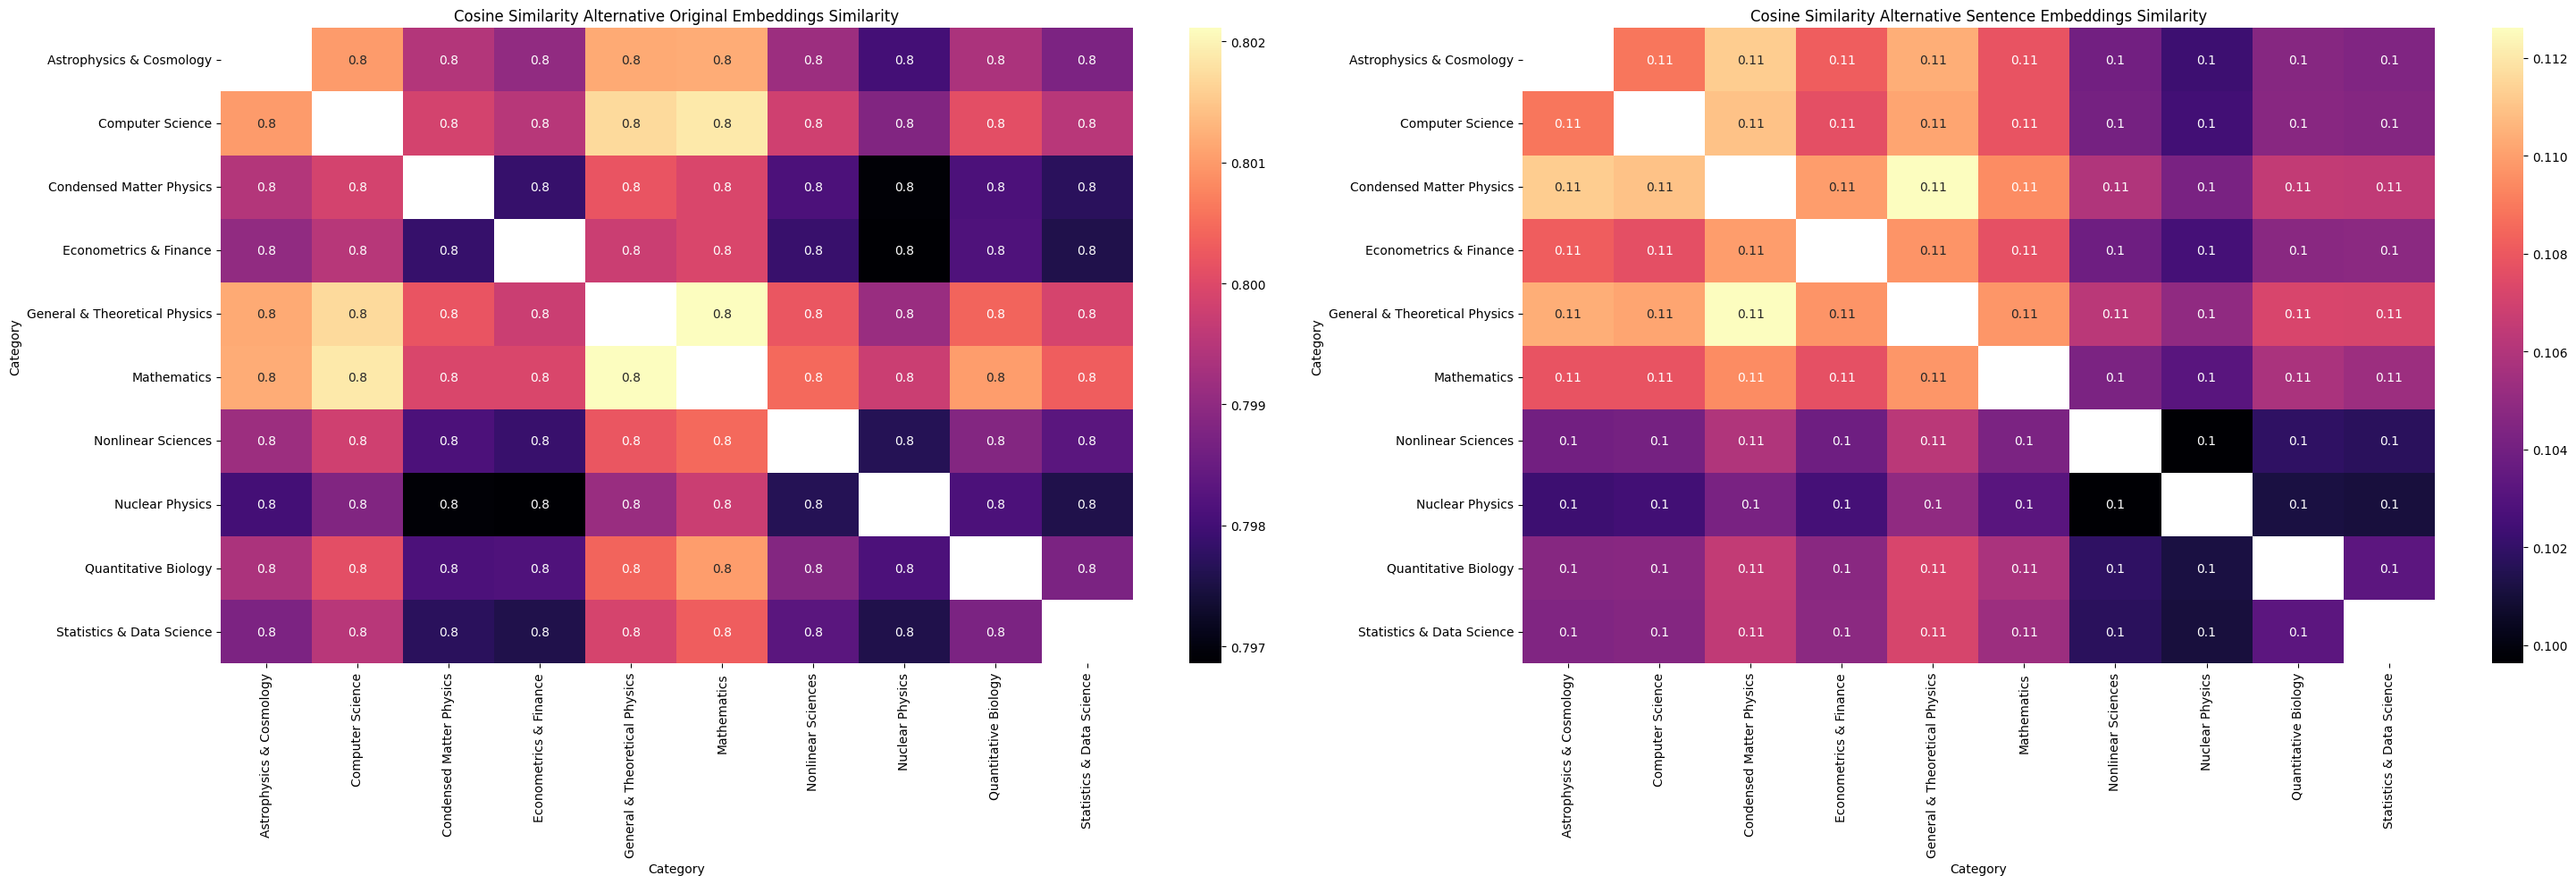

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(30, 10))

#Original Method
original_method = create_similarity_matrix('alternative_joined_embeddings', df_cleaned)
original_norm = pd.DataFrame(zscore(original_method, axis=1, nan_policy='omit'), index=original_method.index, columns=original_method.columns)
plot_similarity_matrix(axes[0], original_method, "Alternative Original Embeddings Similarity")

#Alternative Method
alternative_method = create_similarity_matrix('alternative_sentence_embeddings', df_cleaned)
alternative_norm = pd.DataFrame(zscore(alternative_method, axis=1, nan_policy='omit'), index=alternative_method.index, columns=alternative_method.columns)
plot_similarity_matrix(axes[1], alternative_method, "Alternative Sentence Embeddings Similarity")

plt.tight_layout()
plt.show()